In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import torch

from torch import nn, distributions
import torch.optim as optim
from torch.utils.data import DataLoader
from scipy.stats import norm


/home/brian/devel/sandbox/stochastic_langevin/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Create Dataset

Model:
$$
\theta_1 = 0, \theta_2 = 1, \sigma_x^2 =2 \\
\pi \sim Bernoulli(p=0.5) \\
x_i \sim \pi * N(\theta_1, \sigma_x^2) + (1-\pi) * N(\theta_1 + \theta_2, \sigma_x^2)
$$


NOTE: It looks like to get the multi-model behaviour, I have to use $\sigma_x^2 = 4$ NOT $\sigma_x^2 = 2$ like the paper suggests, most likely a bug in the paper or implementation.

In [2]:
def generate_dataset(theta1, theta2, x_std, N):
    return np.where(np.random.rand(N) >= 0.5, 
                    np.random.normal(theta1, x_std, N), 
                    np.random.normal(theta1 + theta2, x_std, N))


N = 100
theta1, theta2 = 0, 1
x_std = 1.60
np.random.seed(3)
data = generate_dataset(theta1, theta2, x_std, N)
data.shape

(100,)

<AxesSubplot: >

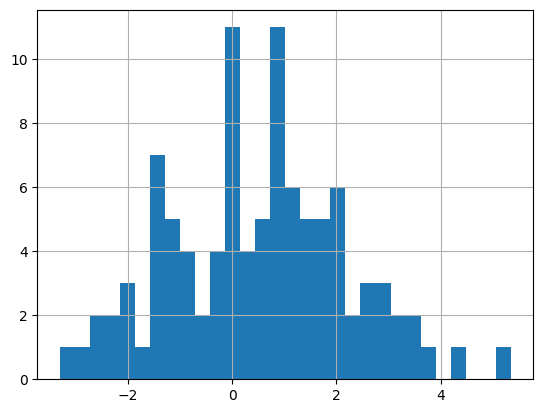

In [3]:
pd.Series(data).hist(bins=30)

# Exact Posterior (Brute Force)

In [4]:
# Make grid of all possible theta1 / theta2
mesh_N = 200
grid = np.meshgrid(np.linspace(-2, 2, mesh_N), np.linspace(-3, 3, mesh_N))
grid = np.stack(grid, axis=2)
grid.shape

(200, 200, 2)

In [5]:
# Compute log pdf of priors
logprob_theta1 = norm.logpdf(grid[:, :, 0], loc=0, scale=np.sqrt(10))
logprob_theta1.shape

logprob_theta2 = norm.logpdf(grid[:, :, 1], loc=0, scale=1)
logprob_theta2.shape

(200, 200)

In [6]:
# Compute log likelihood
# theta1 + theta2 | theta1 ~ N(theta1, sigma2)
log_likelihood = np.zeros(logprob_theta1.shape)
for i, d in enumerate(data):
    prob_x = (0.5 * norm.pdf(d, loc=grid[:, :, 0], scale=np.sqrt(2)) +
              0.5 * norm.pdf(d, loc=grid.sum(axis=2), scale=np.sqrt(2)))
    log_likelihood += np.log(prob_x)

# Normalize log posterior by constant to make it friendlier for np.exp(.) 
unnormalized_log_posterior = log_likelihood + logprob_theta1 + logprob_theta2
log_posterior = unnormalized_log_posterior - unnormalized_log_posterior.max()
posterior = np.exp(log_posterior)
posterior.shape

(200, 200)

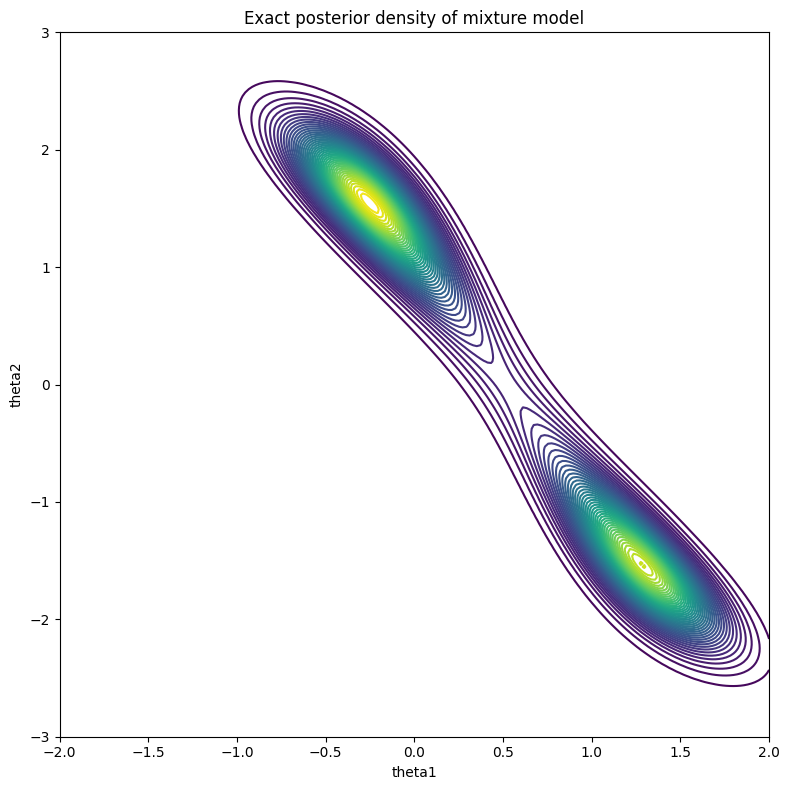

In [7]:
plt.figure(figsize=(8, 8), dpi=100)
xlim = (-2, 2)
ylim = (-3, 3)
plt.xlim(*xlim)
plt.ylim(*ylim)
plt.contour(grid[:, :, 0], grid[:, :, 1], posterior, 
            #extent=xlim+ylim, 
            levels=50)
plt.title('Exact posterior density of mixture model')
plt.xlabel('theta1')
plt.ylabel('theta2')
plt.tight_layout()

# MCMC

Model:
$$
\theta_1 \sim N(0, \sigma_1^2=10) \\
\theta_2 \sim N(0, \sigma_2^2=1) \\
\pi \sim Bernoulli(p=0.5) \\
x_i \sim \pi * N(\theta_1, \sigma_x^2=2) + (1-\pi) * N(\theta_1 + \theta_2, \sigma_x^2=2) \\
$$

In [8]:
with pm.Model() as model:
    theta1 = pm.Normal("theta1", mu=0, sigma=np.sqrt(10))
    theta2 = pm.Normal("theta2", mu=0, sigma=1)
    obs = pm.NormalMixture("obs", w=[0.5, 0.5], 
                           mu=[theta1, theta1 + theta2], 
                           sigma=[np.sqrt(2), np.sqrt(2)], 
                           observed=data)

    idata = pm.sample(5000, chains=1, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [theta1, theta2]


Sampling 1 chain for 2_000 tune and 5_000 draw iterations (2_000 + 5_000 draws total) took 7 seconds.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.1796, but should be close to 0.8. Try to increase the number of tuning steps.


In [9]:
df_mcmc = pd.DataFrame({'theta1': idata.posterior['theta1'][0],
                        'theta2': idata.posterior['theta2'][0]})

df_mcmc.describe()

,theta1,theta2
count,5000.000000,5000.000000
mean,0.564784,-0.060076
std,0.753461,1.495148
min,-1.078029,-2.750147
25%,-0.156058,-1.494594
50%,0.734543,-0.498267
75%,1.255535,1.439065
max,2.023982,2.953421


<AxesSubplot: >

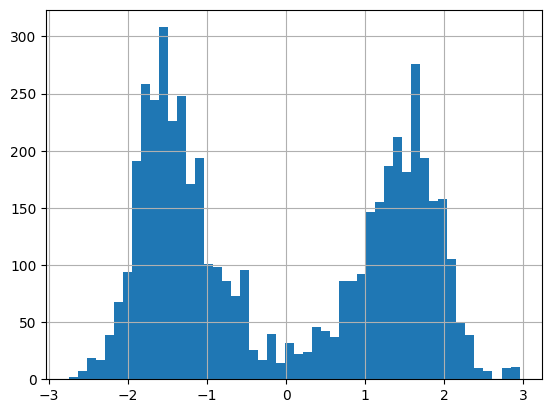

In [10]:
df_mcmc['theta2'].hist(bins=50)

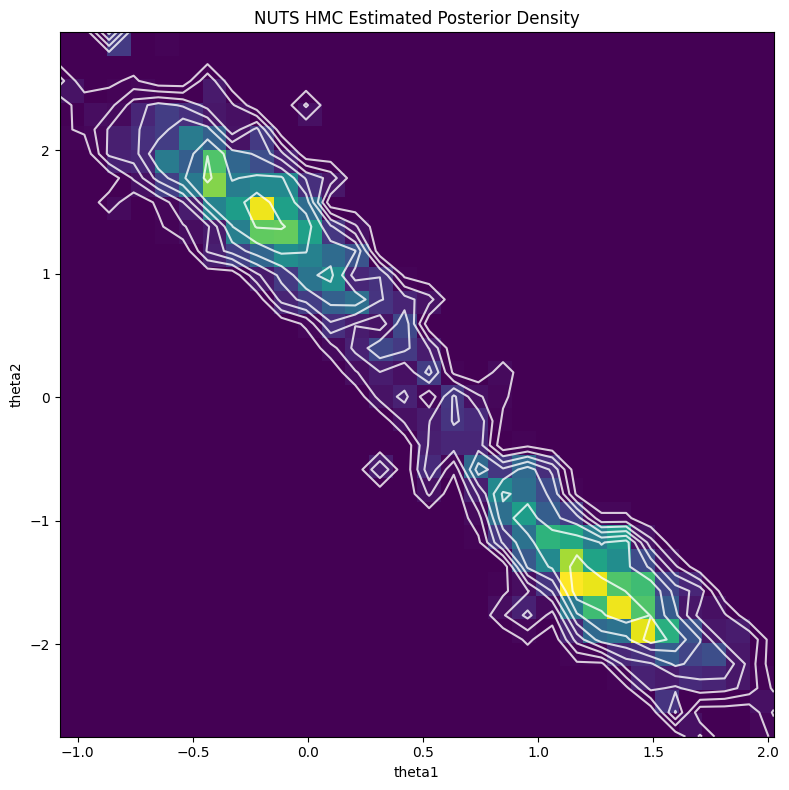

In [11]:
X, Y = df_mcmc.transpose().values
X, Y
plt.figure(figsize=(8, 8), dpi=100).set_facecolor('white')
h, xs, ys, image = plt.hist2d(X, Y, bins=[30, 30])
plt.contour(np.log(h + 3).T, extent=[xs.min(), xs.max(), ys.min(), ys.max()],
            colors='white', alpha=0.8)
plt.title('NUTS HMC Estimated Posterior Density')
plt.xlabel('theta1')
plt.ylabel('theta2')
plt.tight_layout()

<AxesSubplot: title={'center': 'NUTS HMC Samples (PyMC)'}, xlabel='theta1', ylabel='theta2'>

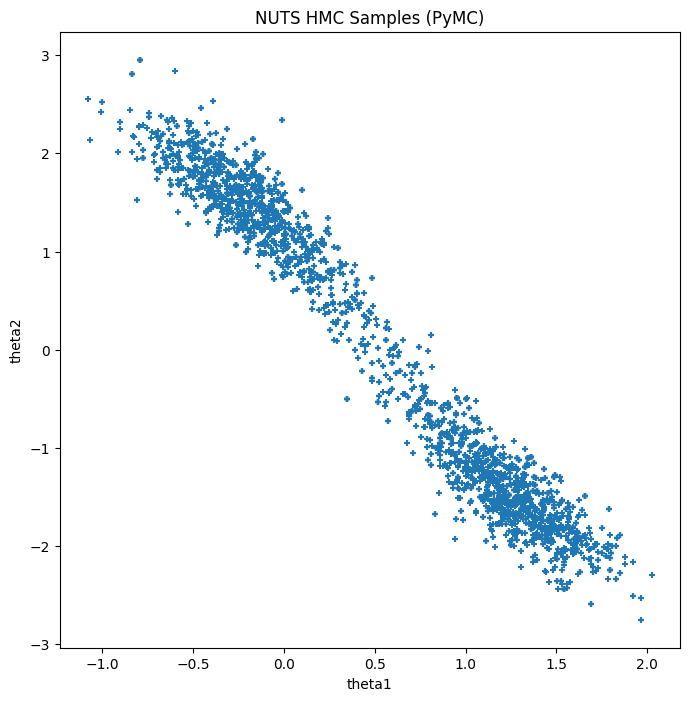

In [12]:
df_mcmc.plot.scatter(x=0, y=1, marker='+', 
                     #xlim=xlim, ylim=ylim,
                     figsize=(8,8),
                title='NUTS HMC Samples (PyMC)')

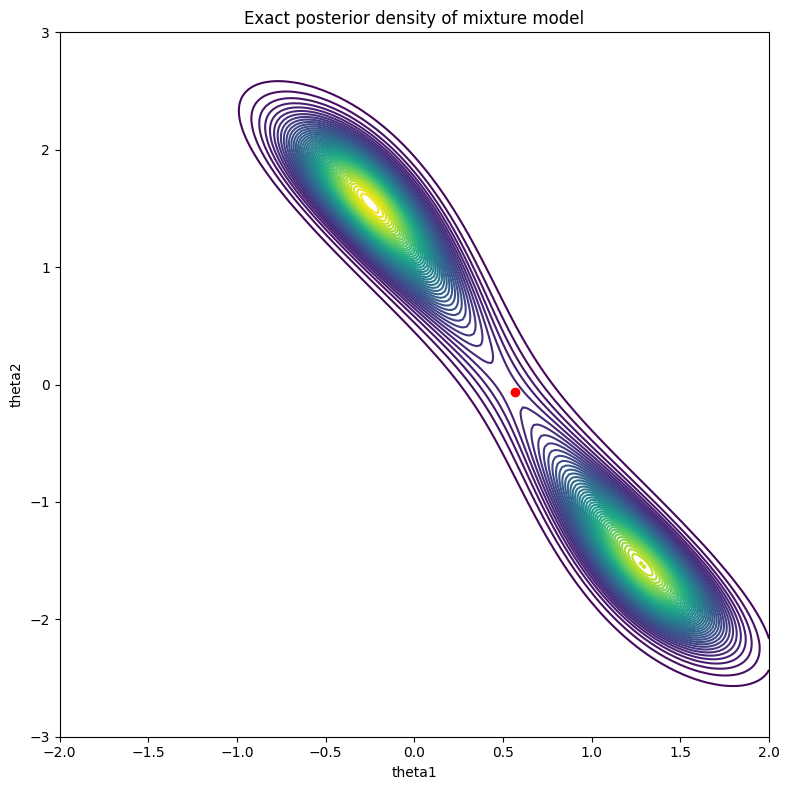

In [13]:
plt.figure(figsize=(8, 8), dpi=100)
plt.xlim(*xlim)
plt.ylim(*ylim)
plt.contour(grid[:, :, 0], grid[:, :, 1], posterior, 
            extent=xlim+ylim, 
            levels=50)
plt.title('Exact posterior density of mixture model')
plt.xlabel('theta1')
plt.ylabel('theta2')
plt.plot(df_mcmc['theta1'].mean(), df_mcmc['theta2'].mean(), 'ro') 
plt.tight_layout()

# Stochastic Gradient Langevin Dynamics

Model:
$$
\theta_1 \sim N(0, \sigma_1^2=10) \\
\theta_2 \sim N(0, \sigma_2^2=1) \\
\pi \sim Bernoulli(p=0.5) \\
x_i \sim \pi * N(\theta_1, \sigma_x^2=2) + (1-\pi) * N(\theta_1 + \theta_2, \sigma_x^2=2) \\
\\
\text{Note: } \theta_1+\theta_2|\theta_1 \sim N(\theta_1, \sigma_2^2)
$$

In [96]:
class MixtureModel(nn.Module):
    def __init__(self, theta1_var, theta2_var, x_var):
        super(MixtureModel, self).__init__()
        self.theta1_var = theta1_var
        self.theta2_var = theta2_var
        self.x_std = torch.sqrt(x_var)
        self.theta = nn.Parameter(torch.ones(2))

    def forward(self):
        mean1 = self.theta[0]
        mean2 = self.theta.sum()
        mixture_means = torch.cat([torch.unsqueeze(mean1, 0), torch.unsqueeze(mean2, 0)])
        return mixture_means

    def _gmm(self, mixture_means):
        mix = distributions.Categorical(torch.ones(2,))
        comp = distributions.Normal(loc=mixture_means, scale=torch.tensor([self.x_std, self.x_std]))
        return distributions.MixtureSameFamily(mix, comp)
   
    def loss(self, mixture_means, batch_data, N):
        log_likelihood = - N / len(batch_data) * self._gmm(mixture_means).log_prob(batch_data).sum()
        log_prior = (torch.nn.functional.gaussian_nll_loss(torch.zeros(1), self.theta[0], self.theta1_var) +
                     torch.nn.functional.gaussian_nll_loss(torch.zeros(1), self.theta[1], self.theta2_var))
        return log_likelihood + log_prior

In [103]:
class MixtureDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        super(MixtureDataset).__init__()
        self.data = torch.tensor(data)
        
    def __len__(self):
        return len(data)

    def __getitem__(self, idx):
        return data[idx]

batch_size = 10
mixture_dataset = MixtureDataset(data)
train_dataloader = DataLoader(mixture_dataset, batch_size=batch_size, shuffle=True)

## Regular Stochastic Gradient Descent

In [110]:
torch_model = MixtureModel(theta1_var=torch.tensor(10.),
                           theta2_var=torch.tensor(1.),
                           x_var=torch.tensor(2.))
optimizer = optim.SGD(torch_model.parameters(), lr=0.01)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5)

print(data.mean())
epoch = 0
for epoch in range(300):
    running_loss = 0.
    for i, batch_data in enumerate(train_dataloader, 0):
        torch_model.zero_grad()

        mixture_means = torch_model()
        theta = torch_model.theta
        loss = torch_model.loss(mixture_means, batch_data, len(data))
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    lr_scheduler.step(running_loss)
    if epoch % 10 == 9:
        print(f'[{epoch+1}, {i+1}] loss: {running_loss:.5f}')
        
parameters = next(torch_model.parameters())
parameters

0.5192015550409603
[10, 10] loss: 1977.56971
[20, 10] loss: 2005.20399
[30, 10] loss: 1991.70087
[40, 10] loss: 1974.39142
[50, 10] loss: 1970.58237
[60, 10] loss: 1969.77981
[70, 10] loss: 1968.95161
[80, 10] loss: 1968.44916
[90, 10] loss: 1968.28572
[100, 10] loss: 1968.37614
[110, 10] loss: 1968.04335
[120, 10] loss: 1967.96796
[130, 10] loss: 1967.95803
[140, 10] loss: 1967.93805
[150, 10] loss: 1967.94128
[160, 10] loss: 1967.93768
[170, 10] loss: 1967.93564
[180, 10] loss: 1967.93393
[190, 10] loss: 1967.93375
[200, 10] loss: 1967.93372
[210, 10] loss: 1967.93357
[220, 10] loss: 1967.93359
[230, 10] loss: 1967.93352
[240, 10] loss: 1967.93354
[250, 10] loss: 1967.93353
[260, 10] loss: 1967.93354
[270, 10] loss: 1967.93354
[280, 10] loss: 1967.93353
[290, 10] loss: 1967.93353
[300, 10] loss: 1967.93353


Parameter containing:
tensor([-0.2578,  1.5600], requires_grad=True)

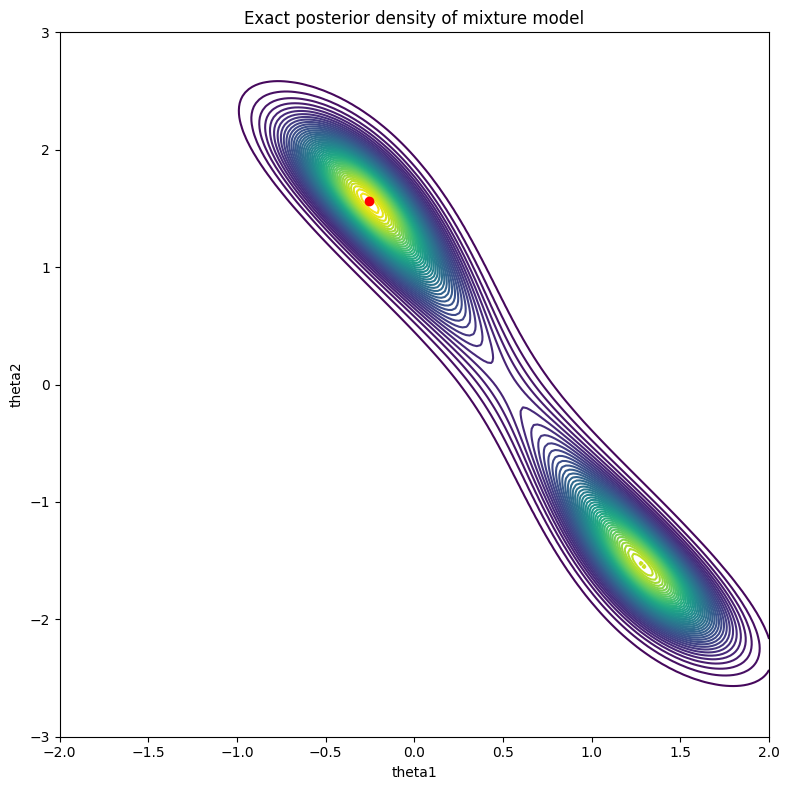

In [111]:
plt.figure(figsize=(8, 8), dpi=100)
plt.xlim(*xlim)
plt.ylim(*ylim)
plt.contour(grid[:, :, 0], grid[:, :, 1], posterior, 
            extent=xlim+ylim, 
            levels=50)
plt.title('Exact posterior density of mixture model')
plt.xlabel('theta1')
plt.ylabel('theta2')
plt.plot(parameters[0].item(), parameters[1].item(), 'ro') 
plt.tight_layout()

## Stochastic Gradient Langevin Dynamics

In [112]:
def compute_lr(t):
    gamma = 0.55
    start = 0.01
    end = 0.0001
    b = 1e4 * len(data) / batch_size / ((end / start) ** (-1/gamma)) 
    a = start * (b ** gamma)
    return a * ((b + t) ** (-gamma))

print(f't=0:     {compute_lr(0):4f}\nt=10000: {compute_lr(10000 * len(data) / batch_size):4f}')

t=0:     0.010000
t=10000: 0.000100


In [118]:
torch_model = MixtureModel(theta1_var=torch.tensor(10.), 
                           theta2_var=torch.tensor(1.), 
                           x_var=torch.tensor(2.))
torch_model

epoch = 0
lr = compute_lr(0)
samples = []
for epoch in range(10000):
    running_loss = 0.
    for i, batch_data in enumerate(train_dataloader, 0):
        inputs = batch_data
        
        torch_model.zero_grad()
      
    
        mixture_means = torch_model()
        theta = torch_model.theta
        loss = torch_model.loss(mixture_means, batch_data, len(data))
        
        loss.backward()
       
        with torch.no_grad():
            for p in torch_model.parameters():
                # TODO FIX ME, need to do it in each dimension
                noise = torch.squeeze(torch.normal(mean=0., std=np.sqrt(lr), size=(1,)))
                grad = 0.5 * lr * p.grad + noise
                p.copy_(p - grad)
                
        running_loss += loss.item()
        lr = compute_lr(len(train_dataloader) * epoch + i)
        
    samples.append([theta[0].item() for x in torch_model.parameters()] 
                   + [theta[1].item() for x in torch_model.parameters()]
                   + [lr])
    
    if epoch % 100 == 99:
        print(f'[{epoch+1}] loss: {running_loss:.3f}, lr: {lr:.5f}')

list(torch_model.parameters())

[100] loss: 1990.639, lr: 0.00124
[200] loss: 1978.197, lr: 0.00085
[300] loss: 1967.708, lr: 0.00069
[400] loss: 1974.877, lr: 0.00059
[500] loss: 1983.660, lr: 0.00052
[600] loss: 1970.817, lr: 0.00047
[700] loss: 1974.377, lr: 0.00043
[800] loss: 1985.780, lr: 0.00040
[900] loss: 1994.623, lr: 0.00038
[1000] loss: 1969.223, lr: 0.00035
[1100] loss: 1971.353, lr: 0.00034
[1200] loss: 1968.107, lr: 0.00032
[1300] loss: 1984.537, lr: 0.00031
[1400] loss: 1968.639, lr: 0.00029
[1500] loss: 1973.797, lr: 0.00028
[1600] loss: 1973.343, lr: 0.00027
[1700] loss: 1969.323, lr: 0.00026
[1800] loss: 1969.548, lr: 0.00026
[1900] loss: 1972.345, lr: 0.00025
[2000] loss: 1977.452, lr: 0.00024
[2100] loss: 1977.162, lr: 0.00024
[2200] loss: 1974.103, lr: 0.00023
[2300] loss: 1967.184, lr: 0.00022
[2400] loss: 1971.609, lr: 0.00022
[2500] loss: 1995.581, lr: 0.00021
[2600] loss: 1968.151, lr: 0.00021
[2700] loss: 1967.997, lr: 0.00021
[2800] loss: 1967.940, lr: 0.00020
[2900] loss: 1969.939, lr: 0.

[Parameter containing:
 tensor([-0.2417,  1.7386], requires_grad=True)]

In [119]:
df_sgld = pd.DataFrame(samples[7000:], columns=['theta1', 'theta2', 'eps'])
df_sgld.describe()

,theta1,theta2,eps
count,3000.000000,3000.000000,3000.000000
mean,-0.244086,1.539001,0.000110
std,0.136085,0.180710,0.000006
min,-0.687952,1.040908,0.000100
25%,-0.341858,1.418988,0.000104
50%,-0.239475,1.528332,0.000109
75%,-0.152475,1.664089,0.000115
max,0.163802,2.131976,0.000122


<AxesSubplot: title={'center': 'SGLD Samples'}, xlabel='theta1', ylabel='theta2'>

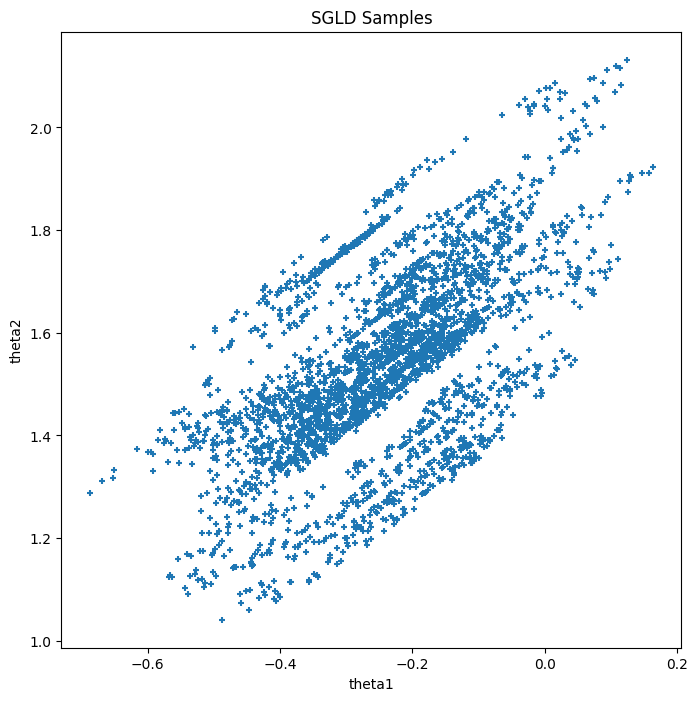

In [120]:
df_sgld.plot.scatter(x=0, y=1, marker='+', 
                     figsize=(8,8),
                     title='SGLD Samples')

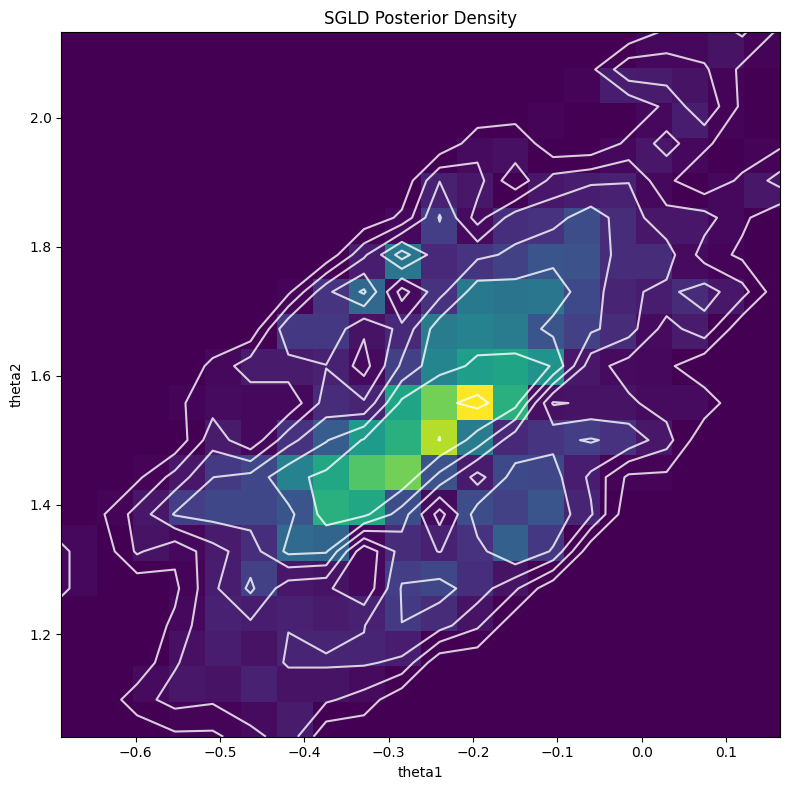

In [121]:
X, Y = df_sgld[['theta1', 'theta2']].transpose().values
X, Y
plt.figure(figsize=(8, 8), dpi=100).set_facecolor('white')
h, xs, ys, image = plt.hist2d(X, Y, bins=[20, 20])
plt.contour(np.log(h + 3).T, extent=[xs.min(), xs.max(), ys.min(), ys.max()],
            colors='white', alpha=0.8)
plt.title('SGLD Posterior Density')
plt.xlabel('theta1')
plt.ylabel('theta2')
plt.tight_layout()
xlim, ylim = (xs.min(), xs.max()), (ys.min(), ys.max())

In [125]:
theta1_adj_mean = (df_sgld['theta1'] * df_sgld['eps']).sum() / df_sgld['eps'].sum()
theta2_adj_mean = (df_sgld['theta2'] * df_sgld['eps']).sum() / df_sgld['eps'].sum()

print(f'Adjusted means:\n * theta1: {theta1_adj_mean}\n * theta2: {theta2_adj_mean}')

Adjusted means:
 * theta1: -0.24448453145803692
 * theta2: 1.5366915030944013


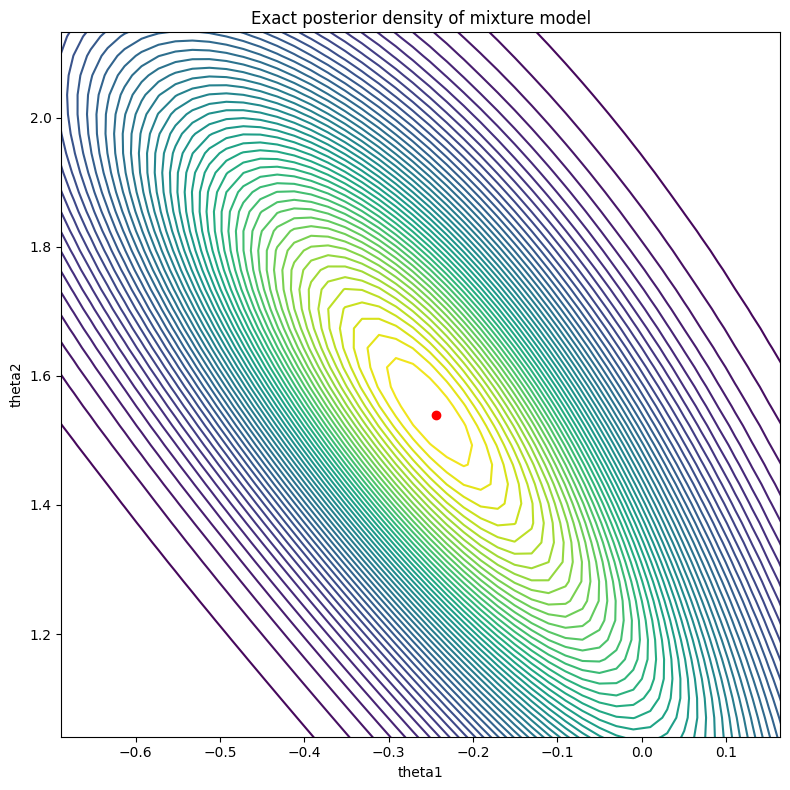

In [124]:
plt.figure(figsize=(8, 8), dpi=100)
plt.xlim(*xlim)
plt.ylim(*ylim)
plt.contour(grid[:, :, 0], grid[:, :, 1], posterior, 
            extent=xlim+ylim, 
            levels=50)
plt.title('Exact posterior density of mixture model')
plt.xlabel('theta1')
plt.ylabel('theta2')
plt.plot(df_sgld['theta1'].mean(), df_sgld['theta2'].mean(), 'ro') 
plt.tight_layout()

# Notes

## 2022-10-04

* Fixed exact solution, just had a typo and needed to re-run
* Fixed another bug in SGD where my loss was not properly sizing likelihood vs. prior (N/batch_size vs. 1)
* Now all the MAP estimate is squarely in the centre of the countour plot maximum

TODO:

* Need to fix SGLD code to update each parameter separately (at least that's what I think the problem is) need to check.

## 2022-10-02

* Figured out what was wrong with SGD: I needed to use a the logpdf of a mixture distribution, NOT $N(0.5 *\theta_1 + 0.5 (\theta_1 + \theta_2), \sigma^2_x)$
* Took me a while to figure out how to use use `torch.distributions.Mixture` main bug was that I was using `torch.tensor([theta1, theta1 + theta2], requires_grad=True)` instead of `torch.cat([torch.unsqueeze(theta1, 0), torch.unsqueeze(theta1+theta2, 0)]`.  The difference is that former creates a new tensor and copies over data (so no lineage to parameters in the computation graph) vs. concat that keeps the lineage.  Additionally, I need to unsqueeze so that cat knows how to deal with tensors vs. scalars.
    * Lots of annoying stuff because I'm not that familiar with PyTorch
* Now problem is that I get something NUTS sample and SGD agree on the MAP estimate, but my "exact" solution doesn't.

TODO:
* Debug "exact" solution to make the contour plot line up with the other two

## 2022-10-01

* Modified data generation so that I actually get a multi-modal distribution by using x_std = 1.6 (vs. x_std=sqrt(2) like the paper says 
    * They must have had a pretty good random seed in order to get a multi-modal distribution, which I can often get with 1.5 but not sqrt(2)
* Made a mistake before relating posterior mean to MAP estimate, which are different.  HMC now more faithfully reproduces the multimodal distribution (approximately)
* But now SGD is quite off.  Theoretically, it should produce something close to the MAP estimate, but it produces something much smaller (with $\theta_2\approx 0$), I narrowed it down to the $\theta_2$ prior with the $\sigma_2^2=1$ makes it so that SGD seems to bind it very close to 0.  
    * Either by widening the variance or decreasing emphasis, I can get it closer to what I think the MAP estimate should be, but it's strange it does this.
    
TODO:
* Investigate why $\theta_2$ prior is pulling it so hard towards 0.
* IDEA: Try to implement the loss function myself instead of using `gaussian_nll_loss`

## 2022-09-30

* Had a bug in the "exact" calculation, now it's lining up with my SGLD much more closely
* HMC mean is strangely not that close to the center
    
TODO:
* Strangely enough, HMC is still kind of far off -- I should probably double check it
* Adjust samples by $\epsilon$ as described in the paper

## 2022-09-29

* Due to the high correlation at the tailend, so we don't get a perfect sample of the distribution like in HMC from the paper 
    * `the simple sample average will over-emphasize the tail end of the sequence where there is higher correlation among the samples, resulting in a higher variance estimator.`
    * `Measuring the sampling threshold will only beimportant if one needs to faithfully represent the posterior distribution with a finite collection of samples`
    
    
TODO:

* Adjust samples by $\epsilon$ as described in the paper
* Play around with lower noise threhold